In [6]:
import os
import time
import torch
import visdom
import argparse
import torch.nn as nn
import torchvision.transforms as tfs
from torch.utils.data import DataLoader
from timm.models.layers import trunc_normal_
from torchvision.datasets.cifar import CIFAR10

In [7]:
class EmbeddingLayer(nn.Module):
    def __init__(self, in_chans, embed_dim, img_size, patch_size):
        super().__init__()
        self.num_tokens = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim
        self.project = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.num_tokens += 1
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_tokens, self.embed_dim))

        # init cls token and pos_embed -> refer timm vision transformer
        # https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py#L391
        nn.init.normal_(self.cls_token, std=1e-6)
        trunc_normal_(self.pos_embed, std=.02)

    def forward(self, x):
        B, C, H, W = x.shape
        embedding = self.project(x)
        z = embedding.view(B, self.embed_dim, -1).permute(0, 2, 1)  # BCHW -> BNC

        # concat cls token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        z = torch.cat([cls_tokens, z], dim=1)

        # add position embedding
        z = z + self.pos_embed
        return z

In [8]:
class MSA(nn.Module):
    def __init__(self, dim=192, num_heads=12, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [9]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, act_layer=nn.GELU, bias=True, drop=0.):
        super().__init__()
        out_features = in_features

        self.fc1 = nn.Linear(in_features, hidden_features, bias=bias)
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop)
        self.fc2 = nn.Linear(hidden_features, out_features, bias=bias)
        self.drop2 = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

In [10]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False,
                 drop=0., attn_drop=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.norm2 = norm_layer(dim)
        self.attn = MSA(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.mlp = MLP(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [11]:
class ViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=192, depth=12,
                 num_heads=12, mlp_ratio=2., qkv_bias=False, drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = nn.LayerNorm
        act_layer = nn.GELU

        self.patch_embed = EmbeddingLayer(in_chans, embed_dim, img_size, patch_size)
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)])

        # final norm
        self.norm = norm_layer(embed_dim)

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

    def forward(self, x):
        x = self.patch_embed(x)
        x = self.blocks(x)
        x = self.norm(x)
        x = self.head(x)[:, 0]
        return x

In [12]:
epochs = 50
batch_size = 128
learning_rate = 0.001
root = './CIFAR10'
validation_split = 0.1

transform_cifar = tfs.Compose([
    tfs.RandomCrop(32, padding=4),
    tfs.RandomHorizontalFlip(),
    tfs.ToTensor(),
    tfs.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])


In [13]:
test_transform_cifar = tfs.Compose([tfs.ToTensor(),
                                    tfs.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

full_train_set = CIFAR10(root=root, train=True, download=True, transform=transform_cifar)
test_set = CIFAR10(root=root, train=False, download=True, transform=test_transform_cifar)

train_size = int((1 - validation_split) * len(full_train_set))
val_size = len(full_train_set) - train_size
train_set, val_set = torch.utils.data.random_split(full_train_set, [train_size, val_size])

train_loader = DataLoader(dataset=train_set, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(dataset=val_set, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(dataset=test_set, shuffle=False, batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:01<00:00, 93045077.76it/s] 


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

In [15]:
# 학습 함수
def train(epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if idx % 100 == 0:
            print(f"Epoch [{epoch+1}], Step [{idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    return train_loss, train_accuracy


# 검증 함수
def validate(epoch):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f"Validation Epoch [{epoch+1}] Loss: {val_loss:.4f}, Accuracy: {val_accuracy*100:.2f}%")
    return val_loss, val_accuracy


# 테스트 함수
def test(epoch):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = correct / total
    print(f"Test Epoch [{epoch+1}] Loss: {test_loss:.4f}, Accuracy: {test_accuracy*100:.2f}%")
    return test_loss, test_accuracy

In [16]:
# 학습 루프
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Training
    train_loss, train_accuracy = train(epoch)

    # Validation
    val_loss, val_accuracy = validate(epoch)

    # 스케줄러 업데이트
    scheduler.step()

    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# 테스트 실행
test_loss, test_accuracy = test(epoch)

Epoch 1/50
Epoch [1], Step [1/352], Loss: 2.5299
Epoch [1], Step [101/352], Loss: 1.8984
Epoch [1], Step [201/352], Loss: 1.7430
Epoch [1], Step [301/352], Loss: 1.5982
Validation Epoch [1] Loss: 1.7584, Accuracy: 35.48%
Epoch 2/50
Epoch [2], Step [1/352], Loss: 1.6761
Epoch [2], Step [101/352], Loss: 1.5916
Epoch [2], Step [201/352], Loss: 1.6256
Epoch [2], Step [301/352], Loss: 1.3663
Validation Epoch [2] Loss: 1.4749, Accuracy: 46.10%
Epoch 3/50
Epoch [3], Step [1/352], Loss: 1.4962
Epoch [3], Step [101/352], Loss: 1.4937
Epoch [3], Step [201/352], Loss: 1.3842
Epoch [3], Step [301/352], Loss: 1.3868
Validation Epoch [3] Loss: 1.3365, Accuracy: 51.36%
Epoch 4/50
Epoch [4], Step [1/352], Loss: 1.3364
Epoch [4], Step [101/352], Loss: 1.4221
Epoch [4], Step [201/352], Loss: 1.2436
Epoch [4], Step [301/352], Loss: 1.3892
Validation Epoch [4] Loss: 1.2366, Accuracy: 54.30%
Epoch 5/50
Epoch [5], Step [1/352], Loss: 1.1886
Epoch [5], Step [101/352], Loss: 1.4164
Epoch [5], Step [201/352], 

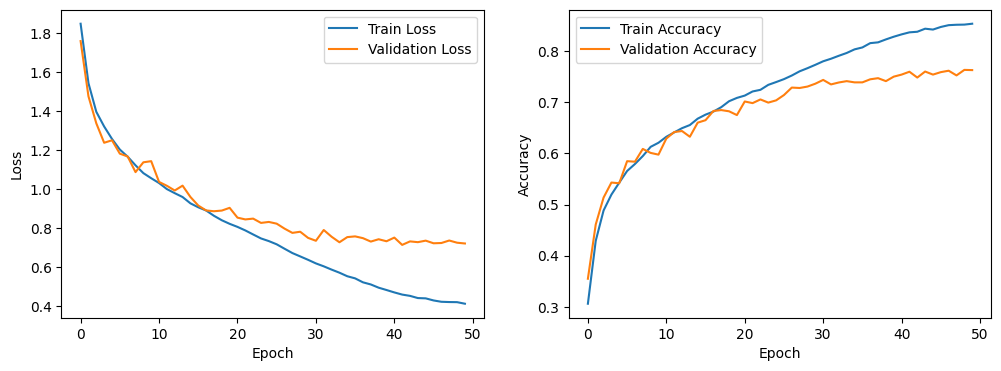

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
print("test accuracy, test loss : ", test_accuracy, test_loss)

test accuracy, test loss :  0.7634 0.716154322594027
